In [1]:
!git clone --depth=1 https://github.com/twintproject/twint.git
!cd /content/twint && pip3 install . -r requirements.txt
!pip install investpy
!pip install vaderSentiment
!pip install nest_asyncio

Cloning into 'twint'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 47 (delta 3), reused 14 (delta 0), pack-reused 0
Unpacking objects: 100% (47/47), done.
Processing /content/twint
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 1.3 MB 27.7 MB/s 
     |████████████████████████████████| 263 kB 56.5 MB/s 
     |████████████████████████████████| 363 kB 49.2 MB/s 
     |████████████████████████████████| 142 kB 74.3 MB/s 
     |████████████████████████████████| 294 kB 59.7 MB/s 
     |██████████████████████

     |████████████████████████████████| 125 kB 31.8 MB/s 


In [2]:
!pip install keras-visualizer

In [4]:
# importing important packages

from ipywidgets import interact, interactive, interact_manual, fixed
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from sklearn.preprocessing import StandardScaler
from  sklearn.metrics import mean_squared_error
import plotly.express as px
from keras_visualizer import visualizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from sklearn import model_selection
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import investpy as ipy
from tqdm import tqdm
import nest_asyncio
import pandas as pd
import numpy as np
import datetime
import twint
import nltk
import math
import re

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Get the stock data

In [7]:
# Construction of the dataset
# Here we consider the dataset for reliance industries
def create_data(input1,stock,input2):
  #yesterday=(datetime.date.today()-datetime.timedelta(1)).strftime('%d/%m/%Y')
  df = ipy.get_stock_historical_data(stock=stock, country='india', from_date=input1, to_date=input2, as_json=False, order='ascending')
  return df

In [8]:
# Let the user choose the dates
# Please note, the lower bound for the start_date is 01/01/2010 and the upper bound of the end_day is yesterday

start_date = input("Enter your start date in dd/mm/yyyy format:")
end_date = input("Enter your end date in dd/mm/yyyy format:")
company = input ("Enter the company code:")

Enter your start date in dd/mm/yyyy format:01/01/2015
Enter your end date in dd/mm/yyyy format:20/05/2021
Enter the company code:ongc


In [9]:
# Get the data

final_data=create_data(start_date, company,end_date).reset_index()
final_data.tail()

,Date,Open,High,Low,Close,Volume,Currency
1573,2021-05-14,116.00,116.0,111.55,112.95,23626454,INR
1574,2021-05-17,113.95,115.4,112.25,114.25,19960144,INR
1575,2021-05-18,115.00,117.5,114.30,116.10,29395736,INR
1576,2021-05-19,114.50,115.8,113.40,114.90,25295576,INR
1577,2021-05-20,113.45,114.7,111.20,111.80,21131044,INR


# Exploratory Data Analysis

In [10]:
fig = px.area(y=final_data["Close"],x=final_data['Date'],title = 'Stock price of historical data (2015-2021)',labels={'x':'Year','y':'Price'})
fig.show()

In [11]:

def moving_average(days, column1):

  # Rolling Mean on Time series

  final_data['{}_days_simple_moving_average of closing values'.format(days)]=final_data[column1].rolling(window=days).mean()

  # Exponential Moving average

  final_data['{}_days_exponential_moving_average of closing values'.format(days)]=final_data[column1].ewm(span=days).mean()
  

  # Rolling standard deviation
  final_data['{}_days_rolling_std of closing values'.format(days)]=final_data[column1].rolling(window=days).std()

  # Plot the data:

  fig, ax = plt.subplots(1, figsize=(15,7))
  
  # closing values
  ax.plot(final_data[column1], color='red', linewidth=1, label='closing values')
  ax.plot(final_data['{}_days_simple_moving_average of closing values'.format(days)], color='green', linewidth=1, label='simple moving average')
  ax.plot(final_data['{}_days_exponential_moving_average of closing values'.format(days)], color='blue', linewidth=1, label=' exponential moving average')
  ax.plot(final_data['{}_days_rolling_std of closing values'.format(days)], color='black', linewidth=2, label=' rolling std')
  ax.grid()
  ax.set_title('{} days moving and exponential avegage'.format(days))
  ax.legend()
  
  plot=fig.tight_layout()
  return plot

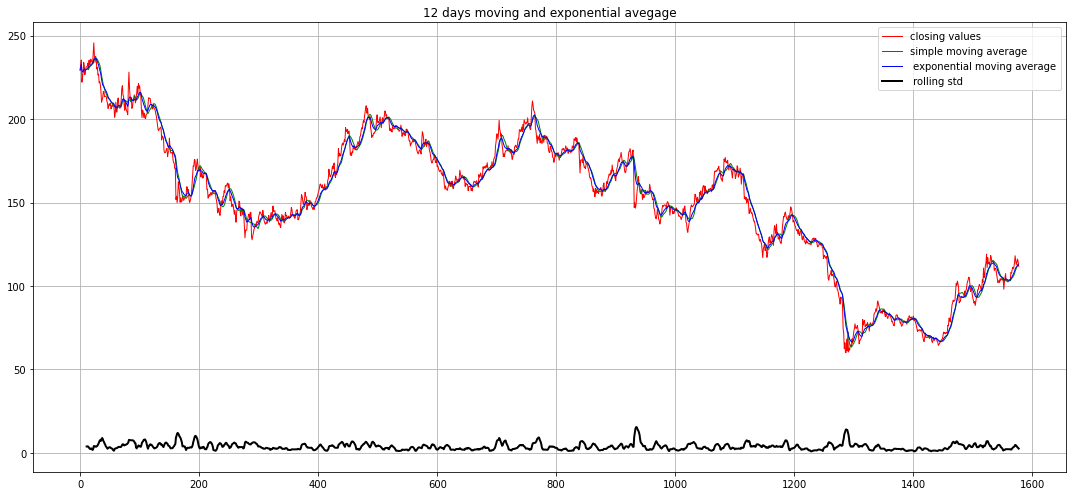

In [12]:
# 12 days moving average
_=moving_average(12,'Close')

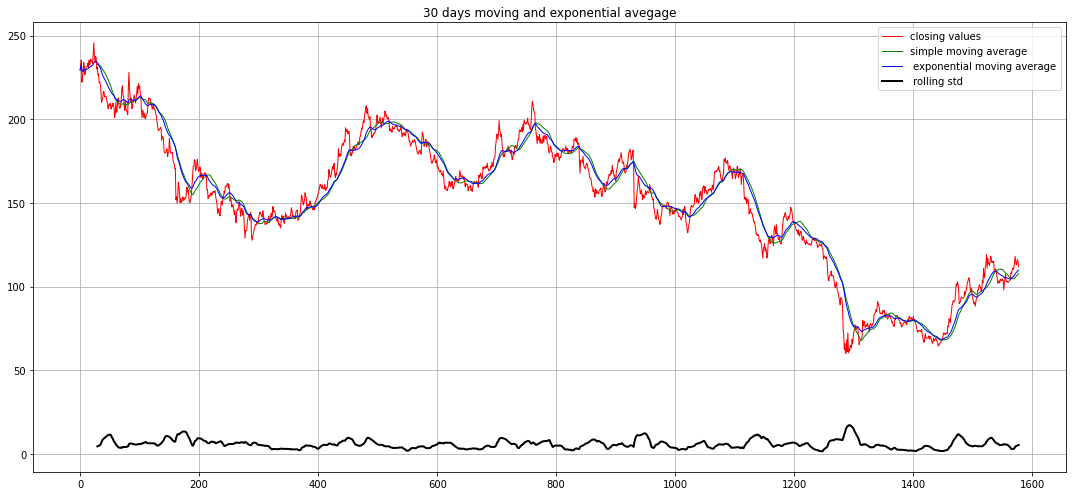

In [13]:
# 30 days moving average:
_=moving_average(30,'Close')


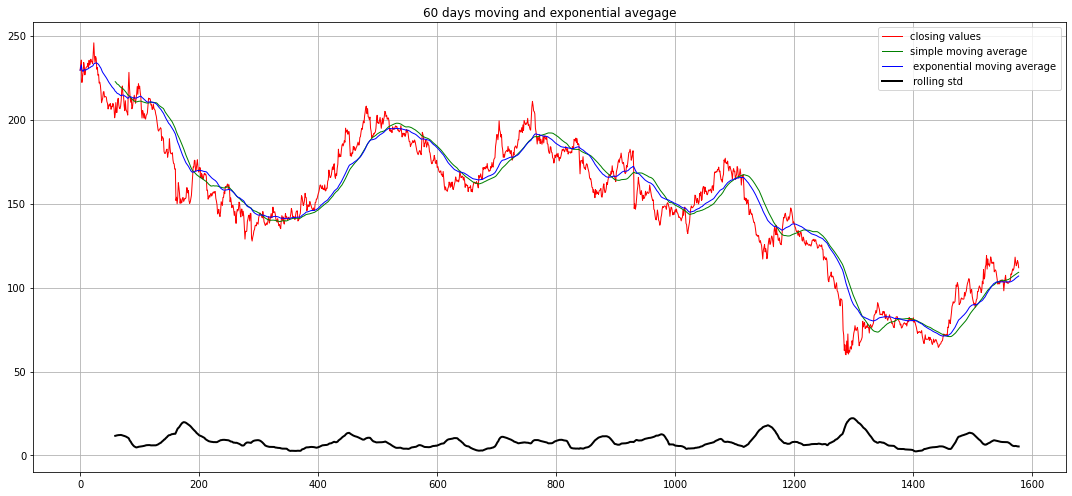

In [14]:
# 60 days moving average

_=moving_average(60,'Close')

In [15]:
final_data['daily_return']=(final_data['Close']/final_data['Close'].shift(1))-1


In [16]:
final_data.head()

,Date,Open,High,Low,Close,Volume,Currency,12_days_simple_moving_average of closing values,12_days_exponential_moving_average of closing values,12_days_rolling_std of closing values,30_days_simple_moving_average of closing values,30_days_exponential_moving_average of closing values,30_days_rolling_std of closing values,60_days_simple_moving_average of closing values,60_days_exponential_moving_average of closing values,60_days_rolling_std of closing values,daily_return
0,2015-01-01,226.83,229.83,226.73,229.37,1849322,INR,NaN,229.370000,NaN,NaN,229.370000,NaN,NaN,229.370000,NaN,NaN
1,2015-01-02,229.40,235.00,229.40,232.80,3736467,INR,NaN,231.227917,NaN,NaN,231.142167,NaN,NaN,231.113583,NaN,0.014954
2,2015-01-05,231.33,238.67,230.67,235.43,6074616,INR,NaN,232.867991,NaN,NaN,232.667753,NaN,NaN,232.600611,NaN,0.011297
3,2015-01-06,232.37,232.63,220.40,222.10,9024993,INR,NaN,229.468957,NaN,NaN,229.755952,NaN,NaN,229.842767,NaN,-0.056620
4,2015-01-07,222.00,227.70,218.73,225.37,8937666,INR,NaN,228.355285,NaN,NaN,228.758042,NaN,NaN,228.887600,NaN,0.014723


In [17]:
final_data=final_data[['Date','Close','Open',"High","Low","Volume","daily_return"]]
final_data.head()

,Date,Close,Open,High,Low,Volume,daily_return
0,2015-01-01,229.37,226.83,229.83,226.73,1849322,NaN
1,2015-01-02,232.80,229.40,235.00,229.40,3736467,0.014954
2,2015-01-05,235.43,231.33,238.67,230.67,6074616,0.011297
3,2015-01-06,222.10,232.37,232.63,220.40,9024993,-0.056620
4,2015-01-07,225.37,222.00,227.70,218.73,8937666,0.014723


Text(0.5, 1.0, 'Daily returns of ONGC stocks')

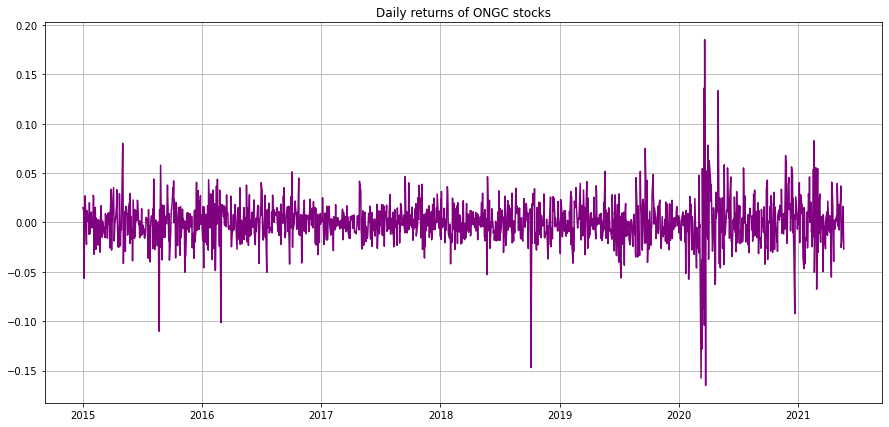

In [18]:
plt.figure(figsize=(15,7))
plt.plot(final_data['Date'],final_data['daily_return'], color='purple')
plt.grid()
plt.title("Daily returns of ONGC stocks")

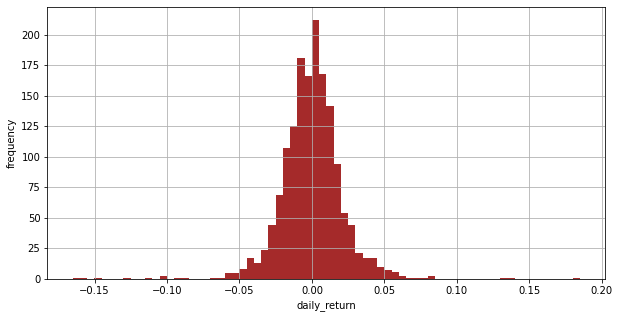

count    1577.000000
mean       -0.000211
std         0.022043
min        -0.165169
25%        -0.011256
50%         0.000273
75%         0.010854
max         0.185094
Name: daily_return, dtype: float64

In [19]:
final_data['daily_return'].hist(bins = 70, figsize = (10,5),color='brown') 
plt.xlabel('daily_return')
plt.ylabel('frequency')
plt.show()
#satistics
final_data['daily_return'].describe()

In [20]:
basket=[]
for i in range(1,len(final_data)):
  if final_data['daily_return'][i]>0:
    box='hope'
  elif final_data['daily_return'][i]==0:
    box= 'constant'
  else:
    box='concern'
  basket.append(box)

In [21]:
temp_df=final_data.dropna().reset_index(drop=True)
temp_df['emotion']=basket
temp_df.head()

,Date,Close,Open,High,Low,Volume,daily_return,emotion
0,2015-01-02,232.80,229.40,235.00,229.40,3736467,0.014954,hope
1,2015-01-05,235.43,231.33,238.67,230.67,6074616,0.011297,hope
2,2015-01-06,222.10,232.37,232.63,220.40,9024993,-0.056620,concern
3,2015-01-07,225.37,222.00,227.70,218.73,8937666,0.014723,hope
4,2015-01-08,227.87,228.63,229.23,223.67,6578928,0.011093,hope


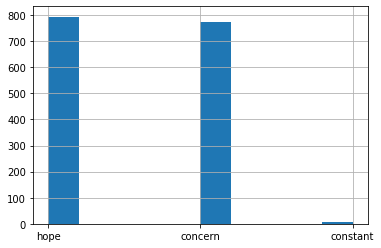

In [22]:
temp_df['emotion'].hist()

In [23]:
import plotly.graph_objects as go

In [24]:
trace0 = go.Violin(
    name = "Opening price",
    y = final_data["Open"],box_visible=True, # draw box plot inside the violin
                points='all', # can be 'outliers', or False
)

trace1 = go.Violin(
    name = "Closing price",
    y = final_data["Close"],box_visible=True, # draw box plot inside the violin
                points='all', # can be 'outliers', or False
)

trace2 = go.Violin(
    name = "High",
    y = final_data["High"],box_visible=True, # draw box plot inside the violin
                points='all', # can be 'outliers', or False
)

trace3 = go.Violin(
    name = "Low",
    y = final_data["Low"],box_visible=True, # draw box plot inside the violin
                points='all', # can be 'outliers', or False
)
layout = go.Layout(
    autosize=False,
    width=700,
    height=500
)
data = [trace0, trace1, trace2, trace3 ]
fig = go.Figure(data=data, layout=layout)
#plotly.offline.iplot(data)
fig.show()

# Collect news data

In [ ]:
nest_asyncio.apply()

#configuration

config = twint.Config()
config.Search = "ONGC"
config.Lang = "en"
config.Since = "2015-01-01"
config.Until = "2015-06-30"
config.Store_csv = True
#config.Output = "/content/drive/MyDrive/bdos_fp_data/tweets_ongc_1.csv"
#running search
#twint.run.Search(config)

In [ ]:
nest_asyncio.apply()

#configuration

config = twint.Config()
config.Search = "ONGC"
config.Lang = "en"
config.Since = "2015-07-01"
config.Until = "2015-12-30"
config.Store_csv = True
#config.Output = "/content/drive/MyDrive/bdos_fp_data/tweets_ongc_2.csv"
#running search
#twint.run.Search(config)

In [ ]:

nest_asyncio.apply()

#configuration

config = twint.Config()
config.Search = "ONGC"
config.Lang = "en"
config.Since = "2016-01-01"
config.Until = "2016-06-30"
config.Store_csv = True
#config.Output = "/content/drive/MyDrive/bdos_fp_data/tweets_ongc_3.csv"
#running search
#twint.run.Search(config)

In [ ]:
nest_asyncio.apply()

#configuration

config = twint.Config()
config.Search = "ONGC"
config.Lang = "en"
config.Since = "2016-07-01"
config.Until = "2016-12-31"
config.Store_csv = True
#config.Output = "/content/drive/MyDrive/bdos_fp_data/tweets_ongc_4.csv"
#running search
#twint.run.Search(config)

In [ ]:
nest_asyncio.apply()

#configuration

config = twint.Config()
config.Search = "ONGC"
config.Lang = "en"
config.Since = "2017-01-01"
config.Until = "2017-05-30"
config.Store_csv = True
#config.Output = "/content/drive/MyDrive/bdos_fp_data/tweets_ongc_5.csv"
#running search
#twint.run.Search(config)

In [ ]:
nest_asyncio.apply()

#configuration

config = twint.Config()
config.Search = "ONGC"
config.Lang = "en"
config.Since = "2017-06-01"
config.Until = "2017-12-31"
config.Store_csv = True
#config.Output = "/content/drive/MyDrive/bdos_fp_data/tweets_ongc_6.csv"
#running search
#twint.run.Search(config)

In [ ]:
nest_asyncio.apply()

#configuration

config = twint.Config()
config.Search = "ONGC"
config.Lang = "en"
config.Since = "2018-01-01"
config.Until = "2018-12-31"
config.Store_csv = True
#config.Output = "/content/drive/MyDrive/bdos_fp_data/tweets_ongc_7.csv"
#running search
#twint.run.Search(config)

In [ ]:
nest_asyncio.apply()

#configuration

config = twint.Config()
config.Search = "ONGC"
config.Lang = "en"
config.Since = "2019-01-01"
config.Until = "2019-06-30"
config.Store_csv = True
#config.Output = "/content/drive/MyDrive/bdos_fp_data/tweets_ongc_8.csv"
#running search
#twint.run.Search(config)

In [ ]:
nest_asyncio.apply()

#configuration

config = twint.Config()
config.Search = "ONGC"
config.Lang = "en"
config.Since = "2019-07-01"
config.Until = "2019-12-31"
config.Store_csv = True
config.Output = "/content/drive/MyDrive/bdos_fp_data/tweets_ongc_9.csv"
#running search
#twint.run.Search(config)

In [ ]:
nest_asyncio.apply()

#configuration

config = twint.Config()
config.Search = "ONGC"
config.Lang = "en"
config.Since = "2020-01-01"
config.Until = "2020-12-31"
config.Store_csv = True
config.Output = "/content/drive/MyDrive/bdos_fp_data/tweets_ongc_10.csv"
#running search
#twint.run.Search(config)

In [ ]:
nest_asyncio.apply()

#configuration

config = twint.Config()
config.Search = "ONGC"
config.Lang = "en"
config.Since = "2021-01-01"
config.Until = "2021-12-31"
config.Store_csv = True
config.Output = "/content/drive/MyDrive/bdos_fp_data/tweets_ongc_11.csv"
#running search
#twint.run.Search(config)

Finally we have gathered all the necessary tweets. Its time to build the dataset.

In [ ]:
data_2015_1sthalf=pd.read_csv("/content/drive/MyDrive/bdos_fp_data/tweets_ongc_1.csv")
data_2015_2ndhalf=pd.read_csv("/content/drive/MyDrive/bdos_fp_data/tweets_ongc_2.csv")
data_2016_1sthalf=pd.read_csv("/content/drive/MyDrive/bdos_fp_data/tweets_ongc_3.csv")
data_2016_2ndhalf=pd.read_csv("/content/drive/MyDrive/bdos_fp_data/tweets_ongc_4.csv")
data_2017_1sthalf=pd.read_csv("/content/drive/MyDrive/bdos_fp_data/tweets_ongc_5.csv")
data_2017_2ndhalf=pd.read_csv("/content/drive/MyDrive/bdos_fp_data/tweets_ongc_6.csv")
data_2018=pd.read_csv("/content/drive/MyDrive/bdos_fp_data/tweets_ongc_7.csv")
data_2019_1sthalf=pd.read_csv("/content/drive/MyDrive/bdos_fp_data/tweets_ongc_8.csv")
data_2019_2ndhalf=pd.read_csv("/content/drive/MyDrive/bdos_fp_data/tweets_ongc_9.csv")
data_2020=pd.read_csv("/content/drive/MyDrive/bdos_fp_data/tweets_ongc_10.csv")
data_2021=pd.read_csv("/content/drive/MyDrive/bdos_fp_data/tweets_ongc_11.csv")


In [ ]:
# Concat all the data
news_data=pd.concat([data_2015_1sthalf,data_2015_2ndhalf,data_2016_1sthalf,
                     data_2016_2ndhalf,data_2017_1sthalf,data_2017_2ndhalf,
                     data_2018,data_2019_1sthalf,data_2019_2ndhalf,
                     data_2020,data_2021])

In [ ]:
news_data.tail()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
10583,1394983497081757706,1394904592031223810,2021-05-19 11:49:17 UTC,2021-05-19,11:49:17,0,2301661700,devsinghrawat7,देवसिंह रावत (DEV),NaN,@manoj_gairola @NewsNationTV @ONGC_ @mybmc @CM...,hi,[],[],[],0,0,1,[],[],https://twitter.com/DEVSINGHRAWAT7/status/1394...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'manoj_gairola', 'name': 'man...",NaN,NaN,NaN,NaN
10584,1394983256290955267,1394983256290955267,2021-05-19 11:48:20 UTC,2021-05-19,11:48:20,0,1666873268,56perumal,Perumal pillai,NaN,Assam: Abducted ONGC employee set to return ho...,en,"[{'screen_name': 'eorganiser', 'name': 'organi...",['https://www.organiser.org/Encyc/2021/5/19/As...,[],0,1,2,[],[],https://twitter.com/56perumal/status/139498325...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
10585,1394982958067556353,1394842913075470339,2021-05-19 11:47:09 UTC,2021-05-19,11:47:09,0,1278941952642215937,vikas10462688,Vikas,NaN,@pcraindia @mygovindia @IndianOilcl @BPCLimite...,en,"[{'screen_name': 'pcraindia', 'name': 'petrole...",[],[],0,0,4,"['guesstheword', 'contestalert', 'conservefutu...",[],https://twitter.com/vikas10462688/status/13949...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'pcraindia', 'name': 'Petrole...",NaN,NaN,NaN,NaN
10586,1394982854862557188,1394842913075470339,2021-05-19 11:46:44 UTC,2021-05-19,11:46:44,0,1366657669914718208,pravu_78,Pravina Wahulkar,NaN,@pcraindia @mygovindia @IndianOilcl @BPCLimite...,en,"[{'screen_name': 'pcraindia', 'name': 'petrole...",[],[],0,0,0,"['guesstheword', 'pcra', 'conservefuture']",[],https://twitter.com/Pravu_78/status/1394982854...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'pcraindia', 'name': 'Petrole...",NaN,NaN,NaN,NaN
10587,1394982832901132292,1394982832901132292,2021-05-19 11:46:39 UTC,2021-05-19,11:46:39,0,3100910929,ramrathore142,Ram Rathore,NaN,INS Kochi of the Indian Navy just rescued 188 ...,en,[],[],['https://pbs.twimg.com/media/E1v5esMUcAUQict....,1,2,3,['cyclonetauktae'],[],https://twitter.com/ramrathore142/status/13949...,False,NaN,1,https://pbs.twimg.com/media/E1v5esMUcAUQict.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [ ]:
# I will keep only those tweets whose language is English
news_data=news_data[news_data['language']=="en"]

In [ ]:
news_data.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,615640769127297024,615640769127297024,2015-06-29 21:59:32 UTC,2015-06-29,21:59:32,0,562113977,exsikkose,Exsikkose,NaN,Deep Industries hires Gas Dehydration System f...,en,[],['http://bit.ly/1g3II1n'],[],0,0,0,[],[],https://twitter.com/Exsikkose/status/615640769...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,615623091599843328,615614686881562624,2015-06-29 20:49:17 UTC,2015-06-29,20:49:17,0,51003218,kabirtaneja,Kabir Taneja,NaN,"@DevirupaM Yes, I think usually went to former...",en,"[{'screen_name': 'nktpnd', 'name': 'ankit pand...",[],[],0,0,0,[],[],https://twitter.com/KabirTaneja/status/6156230...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,615597347246977024,615597347246977024,2015-06-29 19:06:59 UTC,2015-06-29,19:06:59,0,758049516,ppt_search,PPT Search,NaN,initial production testing in ongc PPT Slides ...,en,[],['http://www.ppthunter.com/initial-production-...,[],0,0,0,"['ppt', 'initial', 'production', 'testing', 'i...",[],https://twitter.com/PPT_Search/status/61559734...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,615576939672145922,615576939672145922,2015-06-29 17:45:53 UTC,2015-06-29,17:45:53,0,146905986,sashisai,buyyani sashikanth,NaN,@PetroleumMin where as India companies are th...,en,[],[],[],0,0,0,[],[],https://twitter.com/sashisai/status/6155769396...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,615576356743593984,615576356743593984,2015-06-29 17:43:34 UTC,2015-06-29,17:43:34,0,146905986,sashisai,buyyani sashikanth,NaN,@PetroleumMin our govt is saying MAKE IN INDIA...,en,[],[],[],0,0,0,[],[],https://twitter.com/sashisai/status/6155763567...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [ ]:
news_data.shape


(574729, 36)

In [ ]:
# Now we will drop all the irrelevant columns except the date and the tweets
news_data=news_data[['date','tweet']]

In [ ]:
news_data.head()

,date,tweet
0,2015-06-29,Deep Industries hires Gas Dehydration System f...
1,2015-06-29,"@DevirupaM Yes, I think usually went to former..."
2,2015-06-29,initial production testing in ongc PPT Slides ...
3,2015-06-29,@PetroleumMin where as India companies are th...
4,2015-06-29,@PetroleumMin our govt is saying MAKE IN INDIA...


In [ ]:
# Save the file for future use...
news_data.to_csv('/content/drive/MyDrive/bdos_fp_data/news_data.csv')

In [ ]:
news_data=pd.read_csv('/content/drive/MyDrive/bdos_fp_data/news_data.csv',lineterminator='\n')

In [ ]:
news_data=news_data.iloc[:,1:]
news_data.head()

,date,tweet
0,2015-06-29,Deep Industries hires Gas Dehydration System f...
1,2015-06-29,"@DevirupaM Yes, I think usually went to former..."
2,2015-06-29,initial production testing in ongc PPT Slides ...
3,2015-06-29,@PetroleumMin where as India companies are th...
4,2015-06-29,@PetroleumMin our govt is saying MAKE IN INDIA...


Preprocessing the tweets:

In [ ]:
# Creating final box of words:
nltk.download('stopwords')
from nltk.corpus import stopwords
def final_text(text):
    stopword = set(stopwords.words("english"))
    return " ".join([word for word in re.sub(r'[^a-zA-Z\s]', "",text).lower().split() if word not in stopword])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
for i in tqdm(news_data.itertuples()):
    news_data.at[i[0], 'cleaned_tweets'] = final_text(i[2])

420183it [01:02, 6722.55it/s]


In [ ]:
#Combining all the tweets posted on a single date
news_data['tweet_news_combined'] = news_data.groupby(['date'])['cleaned_tweets'].transform(lambda x: ' '.join(x))

news_data.head()

,date,tweet,cleaned_tweets,tweet_news_combined
1,2015-06-29,"@DevirupaM Yes, I think usually went to former...",devirupam yes think usually went former dghong...,devirupam yes think usually went former dghong...
2,2015-06-29,initial production testing in ongc PPT Slides ...,initial production testing ongc ppt slides htt...,devirupam yes think usually went former dghong...
3,2015-06-29,@PetroleumMin where as India companies are th...,petroleummin india companies ongc taking china...,devirupam yes think usually went former dghong...
4,2015-06-29,@PetroleumMin our govt is saying MAKE IN INDIA...,petroleummin govt saying make india ongc purch...,devirupam yes think usually went former dghong...
5,2015-06-29,@narendramodi Sir Your saying make in india . ...,narendramodi sir saying make india govt instit...,devirupam yes think usually went former dghong...


In [ ]:
processed_data=news_data[['date', 'tweet_news_combined']]

In [ ]:
processed_data.head(100)

,date,tweet_news_combined
1,2015-06-29,devirupam yes think usually went former dghong...
2,2015-06-29,devirupam yes think usually went former dghong...
3,2015-06-29,devirupam yes think usually went former dghong...
4,2015-06-29,devirupam yes think usually went former dghong...
5,2015-06-29,devirupam yes think usually went former dghong...
...,...,...
96,2015-06-25,mumbai news news mumbai mumbai city news citie...
97,2015-06-25,mumbai news news mumbai mumbai city news citie...
98,2015-06-25,mumbai news news mumbai mumbai city news citie...
99,2015-06-25,mumbai news news mumbai mumbai city news citie...


In [ ]:
processed_data.drop_duplicates(inplace =True)
processed_data.isna().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


date                   0
tweet_news_combined    0
dtype: int64

In [ ]:
processed_data.sort_values('date', inplace = True)
processed_data=processed_data.reset_index(drop=True)
processed_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,tweet_news_combined
0,2015-01-01,shelarashish examples cars parked vertically o...
1,2015-01-02,brainstorming options future ongc ould newbury...
2,2015-01-03,ongc well spouts gas east godavari httptcosbel...
3,2015-01-04,phl first time bidding back back leased helico...
4,2015-01-05,russian ltbgtshaleltbgt beating us ongcamps la...


In [ ]:
# Save the file for future use...
processed_data.to_csv('/content/drive/MyDrive/bdos_fp_data/processed_data')

In [6]:
processed_data=pd.read_csv('/content/drive/MyDrive/bdos_fp_data/processed_data')

In [7]:
processed_data=processed_data.iloc[:,1:]
processed_data.head()

,date,tweet_news_combined
0,2015-01-01,shelarashish examples cars parked vertically o...
1,2015-01-02,brainstorming options future ongc ould newbury...
2,2015-01-03,ongc well spouts gas east godavari httptcosbel...
3,2015-01-04,phl first time bidding back back leased helico...
4,2015-01-05,russian ltbgtshaleltbgt beating us ongcamps la...


In [ ]:
!pip install twython

In [ ]:
import twython
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sentiment_analyzer = SentimentIntensityAnalyzer()

In [ ]:
processed_data['scores']=processed_data['tweet_news_combined'].apply(lambda tweet_news_combined:sentiment_analyzer.polarity_scores(tweet_news_combined))

In [ ]:
processed_data.head()

,date,tweet_news_combined,scores
0,2015-01-01,shelarashish examples cars parked vertically o...,"{'neg': 0.122, 'neu': 0.659, 'pos': 0.22, 'com..."
1,2015-01-02,brainstorming options future ongc ould newbury...,"{'neg': 0.011, 'neu': 0.682, 'pos': 0.307, 'co..."
2,2015-01-03,ongc well spouts gas east godavari httptcosbel...,"{'neg': 0.059, 'neu': 0.774, 'pos': 0.167, 'co..."
3,2015-01-04,phl first time bidding back back leased helico...,"{'neg': 0.021, 'neu': 0.845, 'pos': 0.134, 'co..."
4,2015-01-05,russian ltbgtshaleltbgt beating us ongcamps la...,"{'neg': 0.071, 'neu': 0.682, 'pos': 0.247, 'co..."


In [ ]:
scores=pd.DataFrame(list(processed_data['scores']))
scores

,neg,neu,pos,compound
0,0.122,0.659,0.220,0.9936
1,0.011,0.682,0.307,0.9994
2,0.059,0.774,0.167,0.9796
3,0.021,0.845,0.134,0.9485
4,0.071,0.682,0.247,0.9978
...,...,...,...,...
2199,0.055,0.788,0.157,0.9994
2200,0.044,0.803,0.153,0.9999
2201,0.052,0.827,0.121,0.9997
2202,0.030,0.835,0.135,0.9997


In [ ]:
processed_sentiment=pd.concat([processed_data,pd.DataFrame(scores['compound'])], axis=1)

processed_sentiment.head()

,date,tweet_news_combined,scores,compound
0,2015-01-01,shelarashish examples cars parked vertically o...,"{'neg': 0.122, 'neu': 0.659, 'pos': 0.22, 'com...",0.9936
1,2015-01-02,brainstorming options future ongc ould newbury...,"{'neg': 0.011, 'neu': 0.682, 'pos': 0.307, 'co...",0.9994
2,2015-01-03,ongc well spouts gas east godavari httptcosbel...,"{'neg': 0.059, 'neu': 0.774, 'pos': 0.167, 'co...",0.9796
3,2015-01-04,phl first time bidding back back leased helico...,"{'neg': 0.021, 'neu': 0.845, 'pos': 0.134, 'co...",0.9485
4,2015-01-05,russian ltbgtshaleltbgt beating us ongcamps la...,"{'neg': 0.071, 'neu': 0.682, 'pos': 0.247, 'co...",0.9978


In [ ]:
processed_sentiment.to_csv('/content/drive/MyDrive/bdos_fp_data/processed_sentiment.csv')

In [25]:
processed_sentiment=pd.read_csv('/content/drive/MyDrive/bdos_fp_data/processed_sentiment.csv')

In [26]:
list_sentiment=[]
for i in range(len(processed_sentiment['compound'])):
  if processed_sentiment['compound'][i]>0:
    mood=1
  else:
    mood=-1
  list_sentiment.append(mood)

In [27]:
processed_sentiment['sentiment_value']=list_sentiment

In [28]:
processed_sentiment.head()

,Unnamed: 0,date,tweet_news_combined,scores,compound,sentiment_value
0,0,2015-01-01,shelarashish examples cars parked vertically o...,"{'neg': 0.122, 'neu': 0.659, 'pos': 0.22, 'com...",0.9936,1
1,1,2015-01-02,brainstorming options future ongc ould newbury...,"{'neg': 0.011, 'neu': 0.682, 'pos': 0.307, 'co...",0.9994,1
2,2,2015-01-03,ongc well spouts gas east godavari httptcosbel...,"{'neg': 0.059, 'neu': 0.774, 'pos': 0.167, 'co...",0.9796,1
3,3,2015-01-04,phl first time bidding back back leased helico...,"{'neg': 0.021, 'neu': 0.845, 'pos': 0.134, 'co...",0.9485,1
4,4,2015-01-05,russian ltbgtshaleltbgt beating us ongcamps la...,"{'neg': 0.071, 'neu': 0.682, 'pos': 0.247, 'co...",0.9978,1


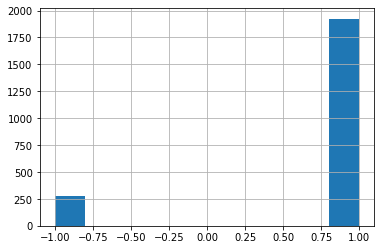

In [29]:
processed_sentiment['sentiment_value'].hist()

In [30]:
final_data.rename({'Date': 'date'}, axis=1, inplace=True)

In [31]:
processed_sentiment['date']=pd.to_datetime(processed_sentiment['date'], format='%Y-%m-%d')

In [32]:
master_data=final_data.merge(processed_sentiment, on='date')

In [33]:
master_data.head()

,date,Close,Open,High,Low,Volume,daily_return,Unnamed: 0,tweet_news_combined,scores,compound,sentiment_value
0,2015-01-01,229.37,226.83,229.83,226.73,1849322,NaN,0,shelarashish examples cars parked vertically o...,"{'neg': 0.122, 'neu': 0.659, 'pos': 0.22, 'com...",0.9936,1
1,2015-01-02,232.80,229.40,235.00,229.40,3736467,0.014954,1,brainstorming options future ongc ould newbury...,"{'neg': 0.011, 'neu': 0.682, 'pos': 0.307, 'co...",0.9994,1
2,2015-01-05,235.43,231.33,238.67,230.67,6074616,0.011297,4,russian ltbgtshaleltbgt beating us ongcamps la...,"{'neg': 0.071, 'neu': 0.682, 'pos': 0.247, 'co...",0.9978,1
3,2015-01-06,222.10,232.37,232.63,220.40,9024993,-0.056620,5,russian shale beating us ongcs last bet corpor...,"{'neg': 0.164, 'neu': 0.711, 'pos': 0.125, 'co...",-0.9994,-1
4,2015-01-07,225.37,222.00,227.70,218.73,8937666,0.014723,6,enthusiasm doesnt hold forever dugalira ugly s...,"{'neg': 0.077, 'neu': 0.794, 'pos': 0.13, 'com...",0.9846,1


In [34]:
master_data=master_data[['date','Close','compound','sentiment_value','Volume','Open','Low','High']]

In [35]:
master_data=master_data.dropna().reset_index(drop=True)
master_data.head()

,date,Close,compound,sentiment_value,Volume,Open,Low,High
0,2015-01-01,229.37,0.9936,1,1849322,226.83,226.73,229.83
1,2015-01-02,232.80,0.9994,1,3736467,229.40,229.40,235.00
2,2015-01-05,235.43,0.9978,1,6074616,231.33,230.67,238.67
3,2015-01-06,222.10,-0.9994,-1,9024993,232.37,220.40,232.63
4,2015-01-07,225.37,0.9846,1,8937666,222.00,218.73,227.70



2. LSTM
3. LSTM with tweets

#Classical LSTM

In [36]:
dataset=master_data['Close'].values
dataset=dataset.astype('float32')

In [37]:
dataset.shape

(1492,)

In [38]:
# Data preprocessing
measure=MinMaxScaler(feature_range=(0,1))
def prepare_data(data):
  data=measure.fit_transform(np.array(data).reshape(-1,1))
  return data

In [39]:
dataset=prepare_data(dataset)
dataset

array([[0.9120624 ],
       [0.9305332 ],
       [0.9446957 ],
       ...,
       [0.2092084 ],
       [0.18686047],
       [0.17635971]], dtype=float32)

In [40]:
# Train test split

train_thres=0.70
train_size=int(len(dataset)*0.70)
val_size=int((len(dataset)-train_size)*0.6)
test_size=int((len(dataset)-train_size)*0.4)

# the data
train=dataset[:train_size,:]
valid=dataset[train_size:train_size+val_size,:]
test=dataset[train_size+val_size:len(dataset),:]

In [41]:
print("Shape of training set: {}".format(train.shape))
print("Shape of valid set: {}".format(valid.shape))
print("Shape of test set: {}".format(test.shape))

Shape of training set: (1044, 1)
Shape of valid set: (268, 1)
Shape of test set: (180, 1)


In [42]:
def memory_window(data, memory_size):
  datax=[]
  datay=[]
  for i in range(len(data)-memory_size-1):
        #print(i)
        window = data[i:(i+memory_size), 0:]
        datax.append(window)
        datay.append(data[i+memory_size, 0:])
        
  return np.array(datax),np.array(datay)


In [43]:
train_x,train_y=memory_window(train,7)
valid_x, valid_y=memory_window(valid,7)
test_x,test_y= memory_window(test,7)

In [44]:
print("Shape of training set: {}".format(train_x.shape))
print("Shape of valid set: {}".format(valid_x.shape))
print("Shape of test set: {}".format(test_x.shape))

Shape of training set: (1036, 7, 1)
Shape of valid set: (260, 7, 1)
Shape of test set: (172, 7, 1)


In [45]:
model_lstm= Sequential([
                        LSTM(units=256,return_sequences=True,
                        activation='tanh',
                        input_shape=train_x.shape[-2:]),
                        Dropout(0.2),
                        LSTM(units=64,activation='tanh',
                             return_sequences=True),
                        Dense(units=1, name='output_layer')                     
])

#Compiling the network
model_lstm.compile(optimizer='adam',
                   loss='mean_squared_error',
                   metrics='mean_squared_error'
                   )

In [46]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 256)            264192    
_________________________________________________________________
dropout (Dropout)            (None, 7, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 64)             82176     
_________________________________________________________________
output_layer (Dense)         (None, 7, 1)              65        
Total params: 346,433
Trainable params: 346,433
Non-trainable params: 0
_________________________________________________________________


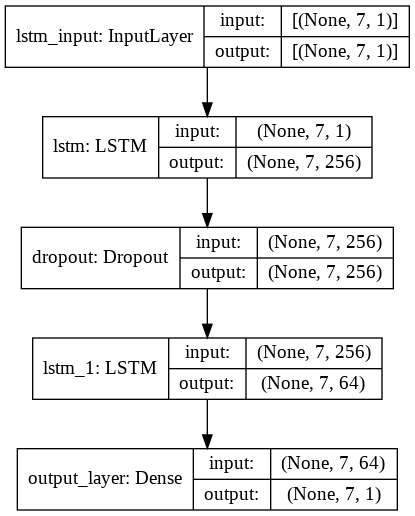

In [55]:
keras.utils.plot_model(model_lstm,to_file="model1.png",
                      show_shapes=True,
                      show_dtype=False,
                      show_layer_names=True,
                      rankdir="TB",
                      expand_nested=False,
                      dpi=96,
                      layer_range=None,
                      )

In [47]:
history_1=model_lstm.fit(train_x,train_y, validation_data=(valid_x,valid_y), epochs=100, batch_size=50, verbose=True)

Epoch 1/100
21/21 [==============================] - 5s 83ms/step - loss: 0.1441 - mean_squared_error: 0.1441 - val_loss: 0.0276 - val_mean_squared_error: 0.0276
Epoch 2/100
21/21 [==============================] - 1s 45ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0270 - val_mean_squared_error: 0.0270
Epoch 3/100
21/21 [==============================] - 1s 45ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 4/100
21/21 [==============================] - 1s 44ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0196 - val_mean_squared_error: 0.0196
Epoch 5/100
21/21 [==============================] - 1s 44ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0154 - val_mean_squared_error: 0.0154
Epoch 6/100
21/21 [==============================] - 1s 44ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 7/100
21/21 [=========

In [45]:
# Predicting the data using the model
pred_train=model_lstm.predict(train_x)
pred_valid=model_lstm.predict(valid_x)

In [46]:
pred_valid=measure.inverse_transform(np.array(pred_valid[0:,0]).reshape(-1,1))

In [76]:
pred_test=model_lstm.predict(test_x)
pred_test=measure.inverse_transform(np.array(pred_test[0:,0]).reshape(-1,1))
y_true=measure.inverse_transform(np.array(test_y).reshape(-1,1))

In [77]:
pred_test[0:,0].shape, y_true.shape

((172,), (172, 1))

In [78]:
y_tr_=pd.DataFrame(y_true,columns=['y_true'])
pred_=pd.DataFrame(pred_test,columns=['pred_test'])
pred_df=pd.concat([y_tr_,pred_],axis=1)
pred_df['diff']=(pred_df['pred_test']-pred_df['y_true'])**2
pred_df.head(250)

,y_true,pred_test,diff
0,77.150002,96.376709,369.666290
1,78.000000,97.066833,363.544128
2,77.000000,96.573616,383.126434
3,76.150002,97.825645,469.833527
4,77.000000,96.475136,379.280914
...,...,...,...
167,101.400002,110.643280,85.438194
168,96.650002,111.315361,215.072769
169,98.099998,113.273392,230.231857
170,98.849998,114.637108,249.232819


In [79]:
classical_lstm_rmse=math.sqrt(mean_squared_error(y_true,pred_test))
classical_lstm_rmse

19.1783389609928

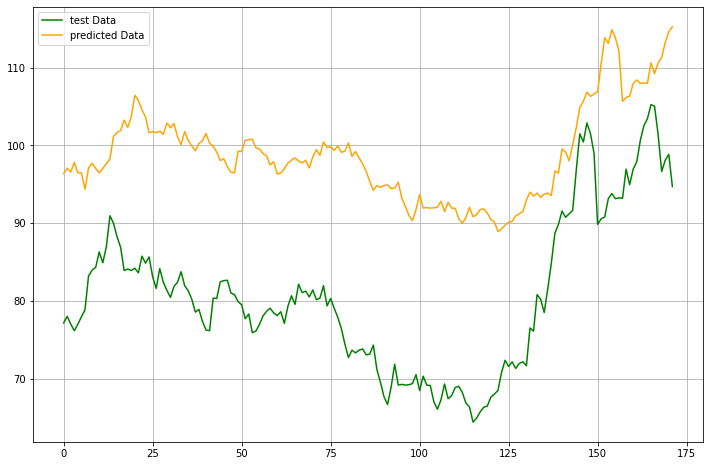

In [80]:
plt.figure(figsize=(12, 8))
plt.plot(y_true, color='green',label='test Data')
plt.plot(pred_test, color='orange',label='predicted Data')
plt.grid()
plt.legend()

In [81]:
# the data
train_data=master_data[['date','Close']].iloc[:train_size,:]
valid_data=master_data[['date','Close']].iloc[train_size:train_size+val_size,:]
test_data=master_data[['date','Close']].iloc[train_size+val_size:len(dataset),:]

In [82]:
a = np.empty((len(test_data)-len(pred_test),1))
b= np.empty((len(valid_data)-len(pred_valid),1))
a[:] = np.nan
pred_test=np.concatenate((a,pred_test),axis=0)
pred_valid=np.concatenate((b,pred_valid),axis=0)

In [83]:
len(pred_valid),len(valid_data)

(268, 268)

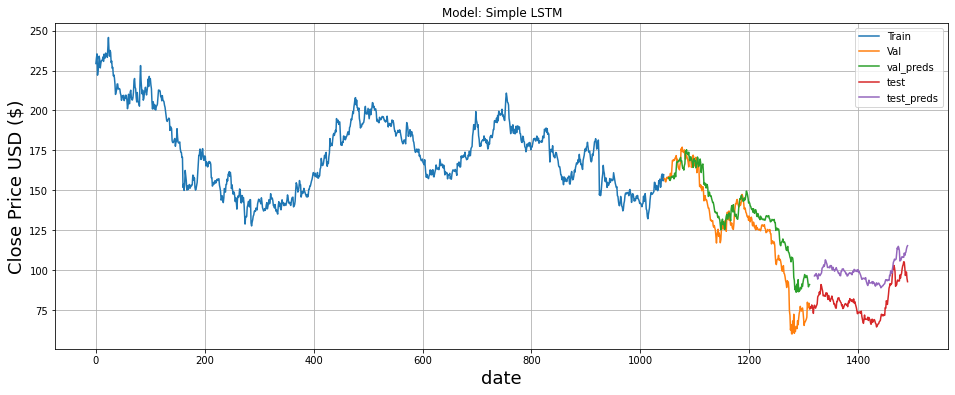

In [87]:
valid_data['predictions'] = pred_valid
test_data['predictions'] = pred_test

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model: Simple LSTM')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close', 'predictions']])
plt.plot(test_data[['Close', 'predictions']])
plt.legend(['Train', 'Val', 'val_preds','test','test_preds'], loc='upper right')
plt.grid()
plt.show()

# LSTM with news headlines

In [56]:
# Filter the data

news_stock=master_data[['date','Close','compound','Volume','Open']]

In [57]:
news_stock.head()

,date,Close,compound,Volume,Open
0,2015-01-01,229.37,0.9936,1849322,226.83
1,2015-01-02,232.80,0.9994,3736467,229.40
2,2015-01-05,235.43,0.9978,6074616,231.33
3,2015-01-06,222.10,-0.9994,9024993,232.37
4,2015-01-07,225.37,0.9846,8937666,222.00


In [58]:
news_stock.shape

(1492, 5)

In [59]:
# Split the data
# Train test split

train_thres=0.70
train_size=int(len(news_stock)*0.70)
val_size=int((len(news_stock)-train_size)*0.6)
test_size=int((len(news_stock)-train_size)*0.4)

# the data
train_news_stock=news_stock.iloc[:train_size,:]
valid_news_stock=news_stock.iloc[train_size:train_size+val_size,:]
test_news_stock=news_stock.iloc[train_size+val_size:len(dataset),:]
del train_news_stock['date']
del valid_news_stock['date']
del test_news_stock['date']

In [60]:
train_news_stock.head()

,Close,compound,Volume,Open
0,229.37,0.9936,1849322,226.83
1,232.80,0.9994,3736467,229.40
2,235.43,0.9978,6074616,231.33
3,222.10,-0.9994,9024993,232.37
4,225.37,0.9846,8937666,222.00


In [61]:
train_x=train_news_stock.iloc[:,1:6]
train_y=train_news_stock.iloc[:,0:1]

valid_x=valid_news_stock.iloc[:,1:6]
valid_y=valid_news_stock.iloc[:,0:1]

test_x=test_news_stock.iloc[:,1:6]
test_y=test_news_stock.iloc[:,0:1]

In [62]:
train_x

,compound,Volume,Open
0,0.9936,1849322,226.83
1,0.9994,3736467,229.40
2,0.9978,6074616,231.33
3,-0.9994,9024993,232.37
4,0.9846,8937666,222.00
...,...,...,...
1039,0.9990,22638400,152.00
1040,0.9984,16694599,159.00
1041,0.9999,10063152,160.15
1042,0.9998,25492224,160.00


In [63]:
# The features
scaler = MinMaxScaler(feature_range=(0,1))
train_x = scaler.fit_transform(train_x)
valid_x = scaler.fit_transform(valid_x)
test_x = scaler.fit_transform(test_x)

# Target data
scaler_target = MinMaxScaler()
train_y=scaler_target.fit_transform(train_y)
valid_y=scaler_target.fit_transform(valid_y)
test_y=scaler_target.fit_transform(test_y)

In [64]:
train_x.shape

(1044, 3)

In [65]:
def multi_memory_window(data_input,data_output, memory_size):
  datax=[]
  datay=[]
  for i in range(len(data_input)-memory_size-1):
        #print(i)
        window = data_input[i:(i+memory_size), 0:]
        datax.append(window)
        datay.append(data_output[i+memory_size, 0:])
        
  return np.array(datax),np.array(datay)

In [66]:
train_x_news,train_y_news=multi_memory_window(train_x,train_y,7)
valid_x_news, valid_y_news=multi_memory_window(valid_x,valid_y,7)
test_x_news,test_y_news= multi_memory_window(test_x,test_y,7)

In [67]:
train_x_news.shape

(1036, 7, 3)

In [68]:
train_y_news.shape

(1036, 1)

In [69]:
model_lstm_news= Sequential([
                        LSTM(units=512,return_sequences=True,
                        activation='tanh',
                        input_shape=(train_x_news.shape[1],train_x_news.shape[2])),
                        LSTM(units=128, activation='tanh',return_sequences=True),
                        LSTM(units=256, activation='tanh',return_sequences=False),
                        Dense(units=train_y_news.shape[1], name='output_layer')
])

#Compiling the network
model_lstm_news.compile(optimizer='adam',loss='mean_squared_error')


In [125]:
model_lstm_news.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 7, 512)            1056768   
_________________________________________________________________
lstm_6 (LSTM)                (None, 7, 128)            328192    
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               394240    
_________________________________________________________________
output_layer (Dense)         (None, 1)                 257       
Total params: 1,779,457
Trainable params: 1,779,457
Non-trainable params: 0
_________________________________________________________________


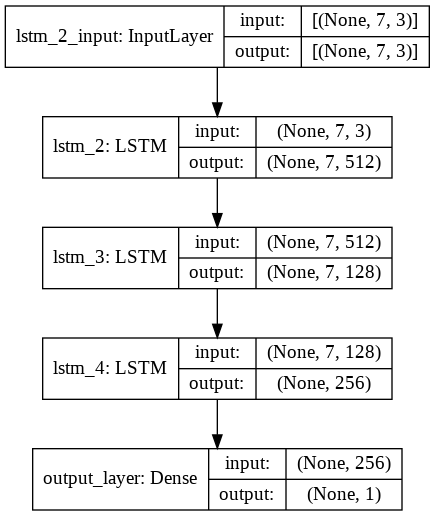

In [70]:
keras.utils.plot_model(model_lstm_news,to_file="model2.png",
                      show_shapes=True,
                      show_dtype=False,
                      show_layer_names=True,
                      rankdir="TB",
                      expand_nested=False,
                      dpi=96,
                      layer_range=None,
                      )

In [126]:
model_lstm_news.fit(train_x_news,train_y_news, validation_data=(valid_x_news,valid_y_news), epochs=100, batch_size=50, verbose=True)

Epoch 1/100
21/21 [==============================] - 6s 78ms/step - loss: 0.0383 - val_loss: 0.0045
Epoch 2/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 3/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 4/100
21/21 [==============================] - 0s 22ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 5/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 6/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0031 - val_loss: 0.0066
Epoch 7/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 8/100
21/21 [==============================] - 0s 22ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 9/100
21/21 [==============================] - 0s 22ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 10/100
21/21 [==============================] - 0s 23ms/step - loss: 0.0029 - val_loss: 0.0036

In [127]:
# Predicting the data using the model

pred_train_news=model_lstm_news.predict(train_x_news)
pred_valid_news=model_lstm_news.predict(valid_x_news)

In [128]:
# Transforming the data into its original form
pred_train_news_data=scaler_target.inverse_transform(pred_train_news)
pred_valid_news_data=scaler_target.inverse_transform(pred_valid_news)

In [129]:
len(test_x_news)

172

In [130]:
pred_test_news=model_lstm_news.predict(test_x_news)
pred_test_news_data=scaler_target.inverse_transform(pred_test_news)
y_true_news=scaler_target.inverse_transform(test_y_news)

In [131]:
print(model_lstm_news.evaluate(test_x_news,test_y_news))

6/6 [==============================] - 0s 8ms/step - loss: 0.0054
0.005436529405415058


In [132]:
mlt_lstm_rmse=math.sqrt(mean_squared_error(y_true_news,pred_test_news_data))
mlt_lstm_rmse

3.011986232755456

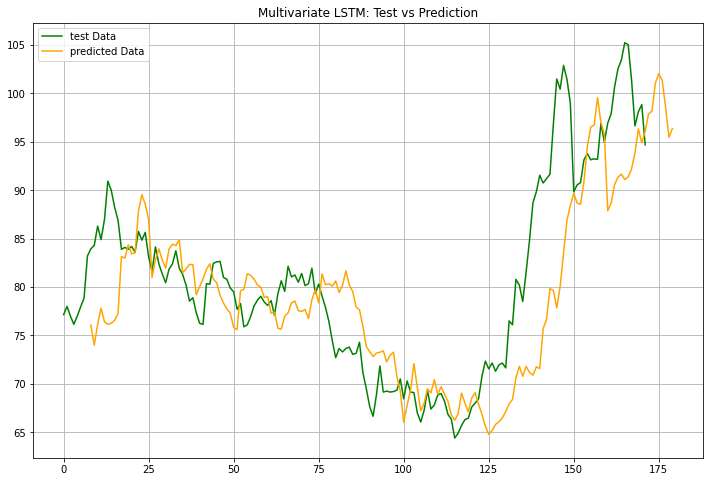

In [154]:
plt.figure(figsize=(12, 8))
plt.plot(y_true_news, color='green',label='test Data')
plt.plot(pred_test_news_data, color='orange',label='predicted Data')
plt.grid()
plt.title('Multivariate LSTM: Test vs Prediction')
plt.legend()

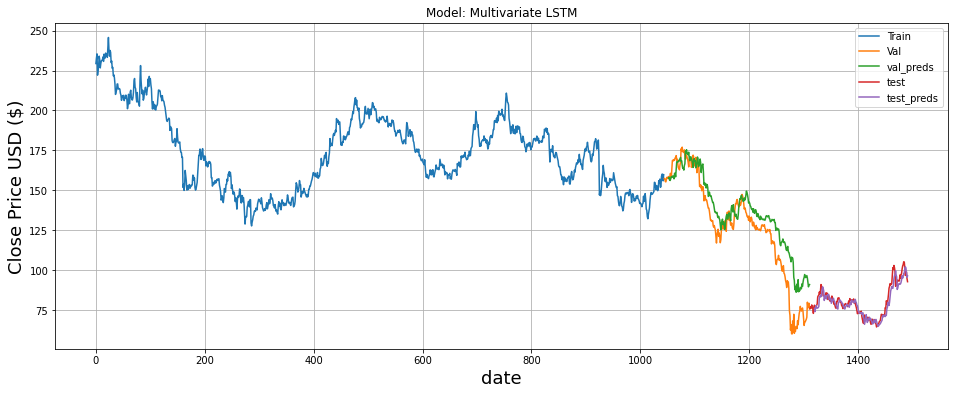

In [153]:
# the data
train_data=master_data[['date','Close']].iloc[:train_size,:]
valid_data=master_data[['date','Close']].iloc[train_size:train_size+val_size,:]
test_data=master_data[['date','Close']].iloc[train_size+val_size:len(dataset),:]

a = np.empty((len(test_data)-len(pred_test_news_data),1))
b= np.empty((len(valid_data)-len(pred_valid_news_data),1))
a[:] = np.nan
pred_test_news_data=np.concatenate((a,pred_test_news_data),axis=0)
pred_valid_news_data=np.concatenate((b,pred_valid_news_data),axis=0)

valid_data['predictions'] = pred_valid
test_data['predictions'] = pred_test_news_data

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model: Multivariate LSTM')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close', 'predictions']])
plt.plot(test_data[['Close', 'predictions']])
plt.legend(['Train', 'Val', 'val_preds','test','test_preds'], loc='upper right')
plt.grid()
plt.show()

LSTM Autoencoder

In [72]:
model_ae=Sequential([
                       LSTM(units=512, return_sequences=True,
                           input_shape=(train_x_news.shape[1],train_x_news.shape[2]),
                           #Use L2 regularizer
                           #kernel_regularizer= regularizers.l2(0.001),
                           activation='tanh'),
                       #20% dropout
                       #Dropout(0.5),
                       LSTM(units=128, return_sequences=False,
                            kernel_regularizer= keras.regularizers.l2(0.001),
                           activation='tanh'),
                       #20% dropout
                       #Dropout(0.2),
                       # In this case, the repeat vector works as a bridge b/w the encoder and the decoder
                       keras.layers.RepeatVector(train_x.shape[1]),
                       #Dropout(0.2),
                       LSTM(units=128, return_sequences=True,
                            kernel_regularizer= keras.regularizers.l2(0.001),
                           activation='tanh'),
                       #Dropout(0.5),
                       LSTM(units=512, return_sequences=True,
                           #Use L2 regularizer
                           #kernel_regularizer= regularizers.l2(0.001),
                           activation='tanh'),
                       keras.layers.TimeDistributed(Dense(train_y_news.shape[1]))
                     ])
# Model compilation
model_ae.compile(optimizer='adam',
                   loss='mean_squared_error',
                   metrics=[tf.keras.metrics.MeanSquaredError()]
                  )

model_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 7, 512)            1056768   
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               328192    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 128)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
lstm_8 (LSTM)                (None, 3, 512)            1312768   
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 1)              513       
Total params: 2,829,825
Trainable params: 2,829,825
Non-trainable params: 0
____________________________________________

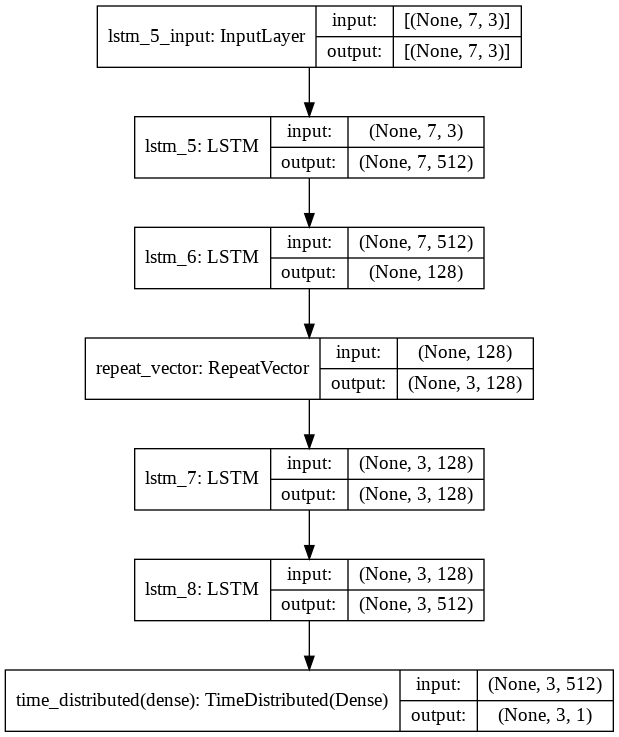

In [73]:
keras.utils.plot_model(model_ae,to_file="model3.png",
                      show_shapes=True,
                      show_dtype=False,
                      show_layer_names=True,
                      rankdir="TB",
                      expand_nested=False,
                      dpi=96,
                      layer_range=None,
                      )

In [136]:
model_ae.fit(train_x_news,train_y_news, validation_data=(valid_x_news,valid_y_news), epochs=500, batch_size=70, verbose=True)

Epoch 1/500
15/15 [==============================] - 8s 140ms/step - loss: 0.6623 - mean_squared_error: 0.0900 - val_loss: 0.5310 - val_mean_squared_error: 0.1052
Epoch 2/500
15/15 [==============================] - 0s 33ms/step - loss: 0.3583 - mean_squared_error: 0.0256 - val_loss: 0.2517 - val_mean_squared_error: 0.0114
Epoch 3/500
15/15 [==============================] - 0s 33ms/step - loss: 0.1903 - mean_squared_error: 0.0057 - val_loss: 0.1379 - val_mean_squared_error: 0.0072
Epoch 4/500
15/15 [==============================] - 0s 33ms/step - loss: 0.1043 - mean_squared_error: 0.0042 - val_loss: 0.0770 - val_mean_squared_error: 0.0060
Epoch 5/500
15/15 [==============================] - 0s 33ms/step - loss: 0.0584 - mean_squared_error: 0.0036 - val_loss: 0.0473 - val_mean_squared_error: 0.0079
Epoch 6/500
15/15 [==============================] - 0s 33ms/step - loss: 0.0357 - mean_squared_error: 0.0046 - val_loss: 0.0304 - val_mean_squared_error: 0.0072
Epoch 7/500
15/15 [========

In [143]:
# Predicting the data using the model

pred_train_news_ae=model_ae.predict(train_x_news)
pred_valid_news_ae=model_ae.predict(valid_x_news)

In [145]:
# Transforming the data into its original form
pred_train_news_data_ae=scaler_target.inverse_transform(pred_train_news_ae[0:,0])
pred_valid_news_data_ae=scaler_target.inverse_transform(pred_valid_news_ae[0:,0])

In [146]:
pred_test_news_ae=model_ae.predict(test_x_news)
pred_test_news_data_ae=scaler_target.inverse_transform(pred_test_news_ae[0:,0])
y_true_news_ae=scaler_target.inverse_transform(test_y_news)

In [147]:
ae_lstm_rmse=math.sqrt(mean_squared_error(y_true_news_ae,pred_test_news_data_ae))
ae_lstm_rmse

3.390465006304907

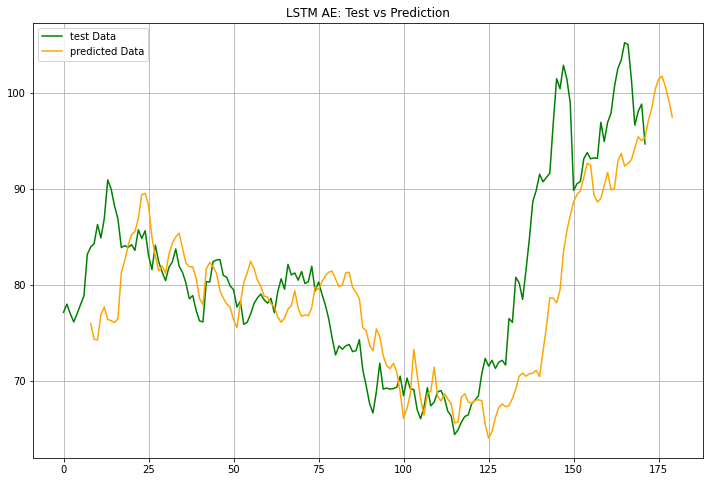

In [151]:
plt.figure(figsize=(12, 8))
plt.plot(y_true_news_ae, color='green',label='test Data')
plt.plot(pred_test_news_data_ae, color='orange',label='predicted Data')
plt.grid()
plt.title('LSTM AE: Test vs Prediction')
plt.legend()

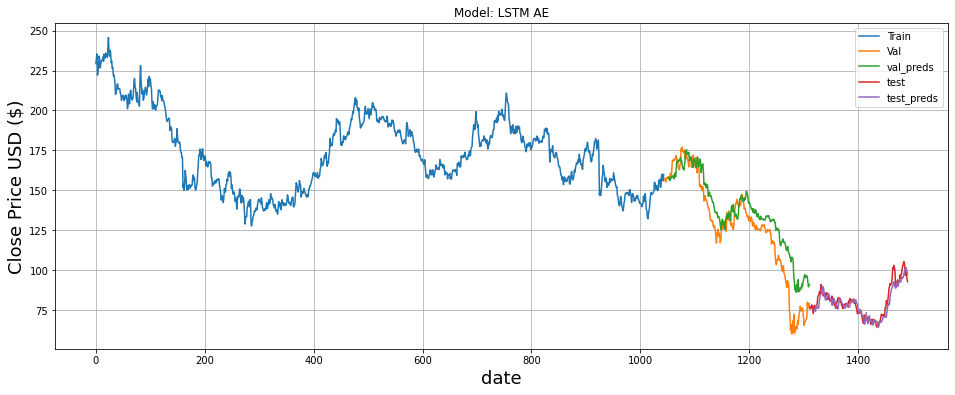

In [152]:
# the data
train_data=master_data[['date','Close']].iloc[:train_size,:]
valid_data=master_data[['date','Close']].iloc[train_size:train_size+val_size,:]
test_data=master_data[['date','Close']].iloc[train_size+val_size:len(dataset),:]

a = np.empty((len(test_data)-len(pred_test_news_data_ae),1))
b= np.empty((len(valid_data)-len(pred_valid_news_data),1))
a[:] = np.nan
pred_test_news_data_ae=np.concatenate((a,pred_test_news_data_ae),axis=0)
pred_valid_news_data=np.concatenate((b,pred_valid_news_data),axis=0)

valid_data['predictions'] = pred_valid
test_data['predictions'] = pred_test_news_data_ae

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model: LSTM AE')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close', 'predictions']])
plt.plot(test_data[['Close', 'predictions']])
plt.legend(['Train', 'Val', 'val_preds','test','test_preds'], loc='upper right')
plt.grid()
plt.show()